# Singapore Flat Resale - Analysis and Modelling

In [1]:
# importing important modules:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, yeojohnson, boxcox
import re
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import warnings
warnings.filterwarnings('ignore')
sns.set(style= 'whitegrid')

## Data Exploration

In [2]:
# Loading datasets:
df_1990 = pd.read_csv("ResaleFlatPricesBasedonApprovalDate19901999.csv")
df_2000 = pd.read_csv("ResaleFlatPricesBasedonApprovalDate2000Feb2012.csv")
df_2013 = pd.read_csv("ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv")
df_2015 = pd.read_csv("ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv")
df_2017 = pd.read_csv("ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")

In [3]:
df_1990.head(1)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000


In [4]:
df_2000.head(1)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0


In [5]:
df_2013.head(1)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0


In [6]:
df_2015.head(1)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0


In [7]:
df_2017.head(1)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0


In [8]:
df_2017['remaining_lease'] = df_2017['remaining_lease'].str.extract('(\d+)').astype(int)
df_2017.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62,265000.0


In [9]:
# Combine the dataset using concat

df1 = pd.concat([df_1990,df_2000,df_2013,df_2015,df_2017],ignore_index=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933302 entries, 0 to 933301
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                933302 non-null  object 
 1   town                 933302 non-null  object 
 2   flat_type            933302 non-null  object 
 3   block                933302 non-null  object 
 4   street_name          933302 non-null  object 
 5   storey_range         933302 non-null  object 
 6   floor_area_sqm       933302 non-null  float64
 7   flat_model           933302 non-null  object 
 8   lease_commence_date  933302 non-null  int64  
 9   resale_price         933302 non-null  float64
 10  remaining_lease      224252 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 78.3+ MB


In [10]:
df1.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN


## Feature engineering:
Our data has some columns that can be further enhanced to be more meaningful for our analysis. Let us try and expand them

In [11]:
df = df1.copy()

In [12]:
# Separating the year and month from the "Month" field
df[['Year', 'Month']] = df['month'].str.split('-', expand=True)
df['Year'] = df['Year'].astype(int)
df['Month'] = df['Month'].astype(int)

In [13]:
df['flat_type'].value_counts()

flat_type
4 ROOM              355013
3 ROOM              297485
5 ROOM              196878
EXECUTIVE            70052
2 ROOM               12025
1 ROOM                1305
MULTI GENERATION       279
MULTI-GENERATION       265
Name: count, dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933302 entries, 0 to 933301
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                933302 non-null  object 
 1   town                 933302 non-null  object 
 2   flat_type            933302 non-null  object 
 3   block                933302 non-null  object 
 4   street_name          933302 non-null  object 
 5   storey_range         933302 non-null  object 
 6   floor_area_sqm       933302 non-null  float64
 7   flat_model           933302 non-null  object 
 8   lease_commence_date  933302 non-null  int64  
 9   resale_price         933302 non-null  float64
 10  remaining_lease      224252 non-null  float64
 11  Year                 933302 non-null  int32  
 12  Month                933302 non-null  int32  
dtypes: float64(3), int32(2), int64(1), object(7)
memory usage: 85.4+ MB


In [15]:
df.head(1)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,Year,Month
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN,1990,1


In [16]:
df.drop(columns = 'month', inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933302 entries, 0 to 933301
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   town                 933302 non-null  object 
 1   flat_type            933302 non-null  object 
 2   block                933302 non-null  object 
 3   street_name          933302 non-null  object 
 4   storey_range         933302 non-null  object 
 5   floor_area_sqm       933302 non-null  float64
 6   flat_model           933302 non-null  object 
 7   lease_commence_date  933302 non-null  int64  
 8   resale_price         933302 non-null  float64
 9   remaining_lease      224252 non-null  float64
 10  Year                 933302 non-null  int32  
 11  Month                933302 non-null  int32  
dtypes: float64(3), int32(2), int64(1), object(6)
memory usage: 78.3+ MB


In [18]:
# Function to extract the integer part from the values

def extract_integer(value):
    # Use regular expression to extract digits from the string
    match = re.match(r'\d+', str(value))
    # If a match is found, return it as an integer; otherwise, return None
    return int(match.group()) if match else None
df['block'] = df['block'].apply(extract_integer)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933302 entries, 0 to 933301
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   town                 933302 non-null  object 
 1   flat_type            933302 non-null  object 
 2   block                933302 non-null  int64  
 3   street_name          933302 non-null  object 
 4   storey_range         933302 non-null  object 
 5   floor_area_sqm       933302 non-null  float64
 6   flat_model           933302 non-null  object 
 7   lease_commence_date  933302 non-null  int64  
 8   resale_price         933302 non-null  float64
 9   remaining_lease      224252 non-null  float64
 10  Year                 933302 non-null  int32  
 11  Month                933302 non-null  int32  
dtypes: float64(3), int32(2), int64(2), object(5)
memory usage: 78.3+ MB


### Missing value treatment:
We have one field that has the highest numbr of missing values, ie. remaining_lease. This may not be an important field, but we have to fill the null values with something or drop them. We will be doing the basic of filling them with a value that depends on the lease commencement date and the Year, minused from the max value in remaining lease, ie., 97

In [38]:
df1 = df.copy()
df1.describe()

,block,floor_area_sqm,lease_commence_date,resale_price,remaining_lease,Year,Month
count,933302.000000,933302.000000,933302.000000,9.333020e+05,224252.000000,933302.000000,933302.000000
mean,348.864373,95.686682,1988.341345,3.227021e+05,74.072829,2006.285877,6.552640
std,255.117098,25.815137,10.729018,1.722619e+05,13.532225,9.401191,3.402846
min,1.000000,28.000000,1966.000000,5.000000e+03,41.000000,1990.000000,1.000000
25%,127.000000,73.000000,1981.000000,1.945000e+05,63.000000,1999.000000,4.000000
50%,302.000000,93.000000,1986.000000,2.990000e+05,74.000000,2005.000000,7.000000
75%,534.000000,113.000000,1996.000000,4.200000e+05,86.000000,2014.000000,9.000000
max,999.000000,366.700000,2020.000000,1.588000e+06,97.000000,2024.000000,12.000000


In [39]:
df1.isnull().sum()

town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        709050
Year                        0
Month                       0
dtype: int64

In [40]:
#handle the null values 
df1['remaining_lease'].fillna(97-(df1['Year']-df1['lease_commence_date']),inplace=True)

mask = df1['remaining_lease']>97 # boolean filter condition
df1 = df1[~mask] # inverting the filter condition to have values less than equal to 97 only.

In [41]:
df1.isnull().sum()

town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
remaining_lease        0
Year                   0
Month                  0
dtype: int64

In [42]:
df1.shape # shows reduced loss of data

(933251, 12)

### Data formatting

In [43]:
df1['flat_type'].value_counts()

flat_type
4 ROOM              354999
3 ROOM              297485
5 ROOM              196854
EXECUTIVE            70039
2 ROOM               12025
1 ROOM                1305
MULTI GENERATION       279
MULTI-GENERATION       265
Name: count, dtype: int64

In [44]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 933251 entries, 0 to 933301
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   town                 933251 non-null  object 
 1   flat_type            933251 non-null  object 
 2   block                933251 non-null  int64  
 3   street_name          933251 non-null  object 
 4   storey_range         933251 non-null  object 
 5   floor_area_sqm       933251 non-null  float64
 6   flat_model           933251 non-null  object 
 7   lease_commence_date  933251 non-null  int64  
 8   resale_price         933251 non-null  float64
 9   remaining_lease      933251 non-null  float64
 10  Year                 933251 non-null  int32  
 11  Month                933251 non-null  int32  
dtypes: float64(3), int32(2), int64(2), object(5)
memory usage: 85.4+ MB


In [45]:
df1['flat_model'].value_counts()

flat_model
Model A                   197185
Improved                  169672
New Generation            110821
NEW GENERATION             78898
IMPROVED                   73577
MODEL A                    70370
Premium Apartment          47423
Simplified                 34522
Apartment                  25782
Standard                   25310
SIMPLIFIED                 23258
Maisonette                 17598
STANDARD                   17375
MAISONETTE                 12214
Model A2                   10209
APARTMENT                   9889
DBSS                        3369
Adjoined flat               1261
Model A-Maisonette          1104
MODEL A-MAISONETTE           982
Terrace                      449
Type S1                      443
MULTI GENERATION             279
Multi Generation             265
TERRACE                      247
Type S2                      219
2-room                       138
Premium Apartment Loft       113
Premium Maisonette            86
Improved-Maisonette           83

In [46]:
df1['flat_model'] = df1['flat_model'].str.upper()

In [47]:
df1['flat_model'].value_counts()

flat_model
MODEL A                   267555
IMPROVED                  243249
NEW GENERATION            189719
SIMPLIFIED                 57780
PREMIUM APARTMENT          47429
STANDARD                   42685
APARTMENT                  35671
MAISONETTE                 29812
MODEL A2                   10209
DBSS                        3369
MODEL A-MAISONETTE          2086
ADJOINED FLAT               1261
TERRACE                      696
MULTI GENERATION             544
TYPE S1                      443
TYPE S2                      219
2-ROOM                       159
IMPROVED-MAISONETTE          127
PREMIUM APARTMENT LOFT       113
PREMIUM MAISONETTE            86
3GEN                          39
Name: count, dtype: int64

In [48]:
df1['flat_type'] = df1['flat_type'].str.replace('MULTI-GENERATION', 'MULTI GENERATION')

In [49]:
df1['flat_type'].value_counts()

flat_type
4 ROOM              354999
3 ROOM              297485
5 ROOM              196854
EXECUTIVE            70039
2 ROOM               12025
1 ROOM                1305
MULTI GENERATION       544
Name: count, dtype: int64

### New columns

In [50]:
# Adding a new feature to improve results:
# per_sqm rate and 
df1['sqm_rate'] = df1['resale_price'] / df1['floor_area_sqm']
df1['property_holding_age'] = df1['Year'] - df1['lease_commence_date']
# property age:
current_year = datetime.datetime.now().year
df1['age_of_property']= current_year - df1['lease_commence_date']

In [51]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 933251 entries, 0 to 933301
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   town                  933251 non-null  object 
 1   flat_type             933251 non-null  object 
 2   block                 933251 non-null  int64  
 3   street_name           933251 non-null  object 
 4   storey_range          933251 non-null  object 
 5   floor_area_sqm        933251 non-null  float64
 6   flat_model            933251 non-null  object 
 7   lease_commence_date   933251 non-null  int64  
 8   resale_price          933251 non-null  float64
 9   remaining_lease       933251 non-null  float64
 10  Year                  933251 non-null  int32  
 11  Month                 933251 non-null  int32  
 12  sqm_rate              933251 non-null  float64
 13  property_holding_age  933251 non-null  int64  
 14  age_of_property       933251 non-null  int64  
dtypes: fl

## Skewness and Outliers:

### Skew check and transformation:
We are to check the skewness of the data to understand how the data has been distributed and to make the data symmetrical as required.

Interpreting Skewness
Symmetric Distribution (Normal Distribution)

Skewness ≈ 0: The data is symmetrically distributed around the mean. A perfectly normal distribution has a skewness of 0.
Positive Skew (Right-Skewed)

Skewness > 0: The tail on the right side of the distribution is longer or fatter than the left side. The mean and median will be greater than the mode.
Example: Income distribution in most countries, where a small number of people have very high incomes, causing a long right tail.
Negative Skew (Left-Skewed)

Skewness < 0: The tail on the left side of the distribution is longer or fatter than the right side. The mean and median will be less than the mode.
Example: Age of retirement, where most people retire around a certain age but some retire much earlier, causing a long left tail.

In [154]:
df1.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,Year,Month,sqm_rate,property_holding_age,age_of_property
0,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,84.0,1990,1,290.322581,13,47
1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,84.0,1990,1,193.548387,13,47
2,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,84.0,1990,1,258.064516,13,47
3,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,84.0,1990,1,193.548387,13,47
4,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,83.0,1990,1,646.575342,14,48


In [52]:
df_s = df1.copy()

In [53]:
numeric_columns = ['block','floor_area_sqm','lease_commence_date','resale_price','remaining_lease','Year','Month','sqm_rate','property_holding_age','age_of_property']

In [54]:
# Getting the skew scores:

for col in numeric_columns:
    print(col)
    print(skew(df_s[col]))

block
0.5357936858806364
floor_area_sqm
0.3668224932849848
lease_commence_date
0.6545938706688128
resale_price
0.9561178423312855
remaining_lease
-0.6460161882267788
Year
0.2923833485795792
Month
-0.029174029756940282
sqm_rate
1.0890133099777124
property_holding_age
0.6990311467984847
age_of_property
-0.6545938706688068


### Inference from skew scores:
Usually the skew scores mean the below:
* Fairly Symmetrical	-0.5 to 0.5
* Moderate Skewed	-0.5 to -1.0 and 0.5 to 1.0
* Highly Skewed	< -1.0 and > 1.0

That being said, our columns of month, year and floor_area_sqm seem quite symmetrical, while property_holding_age, age_of_property, lease_commence_date and the dependent variable resale_price show moderate skewness, excluding remaining_lease and sqm_rate which show high skewness.

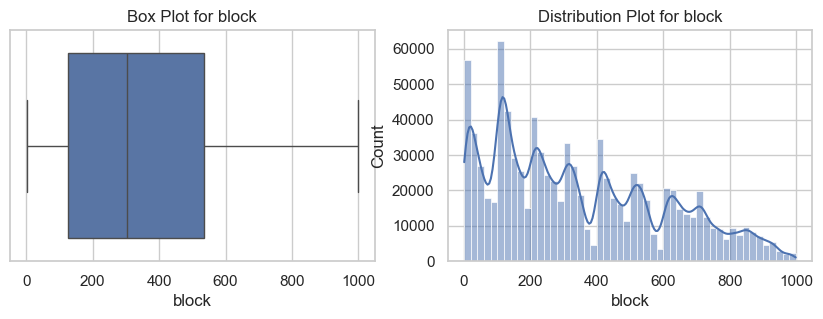

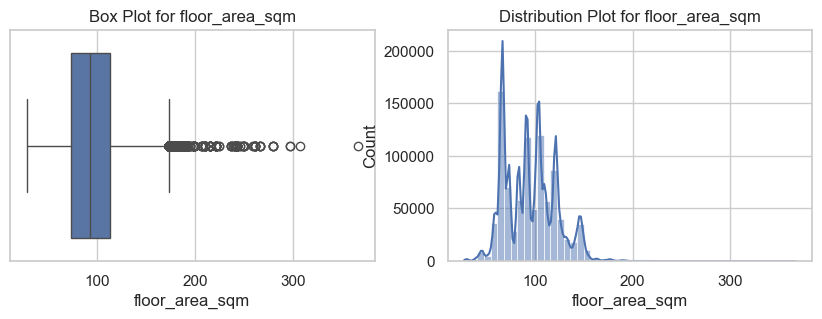

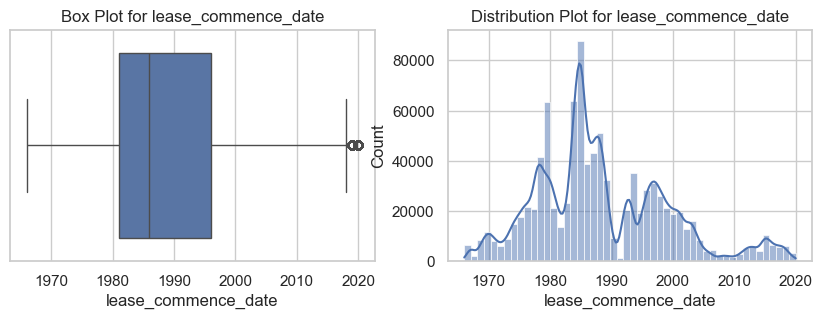

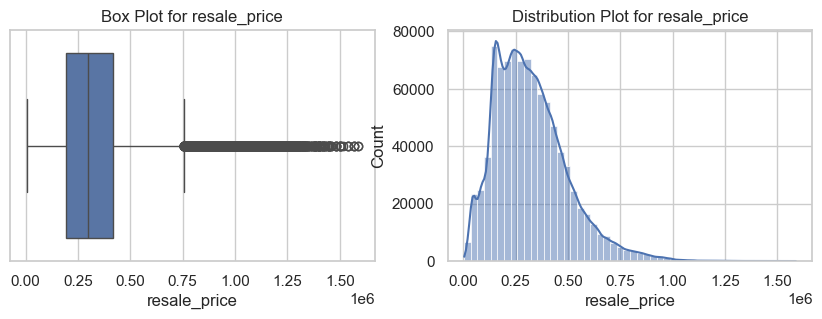

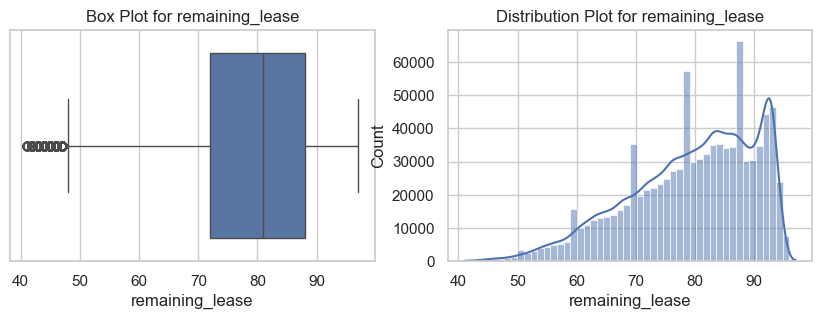

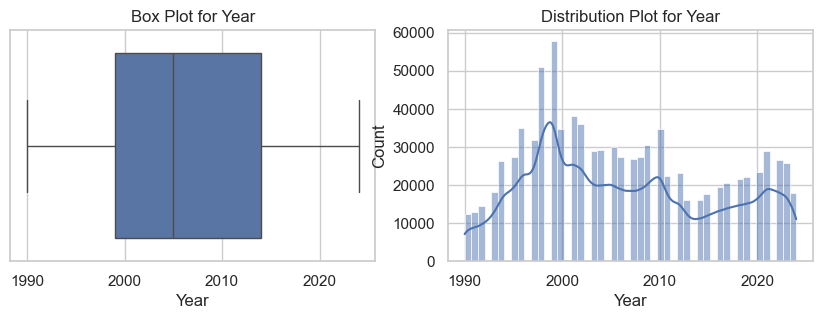

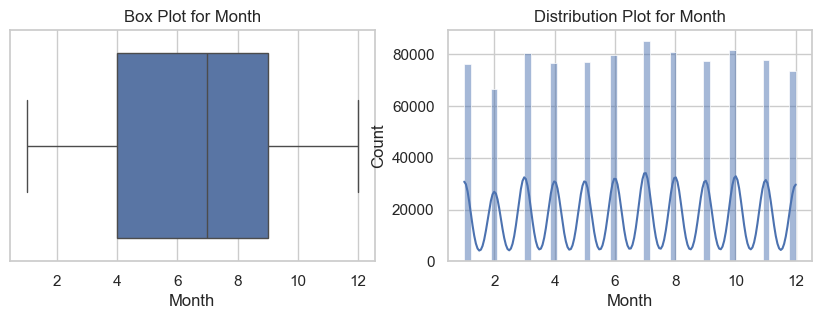

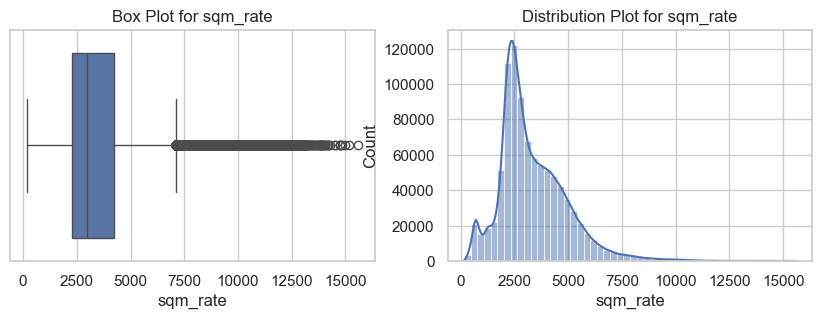

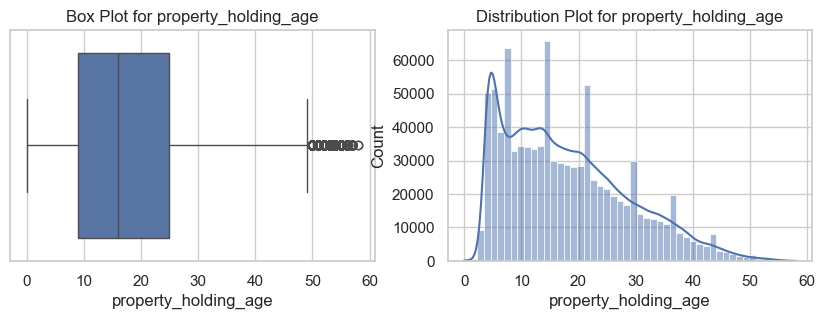

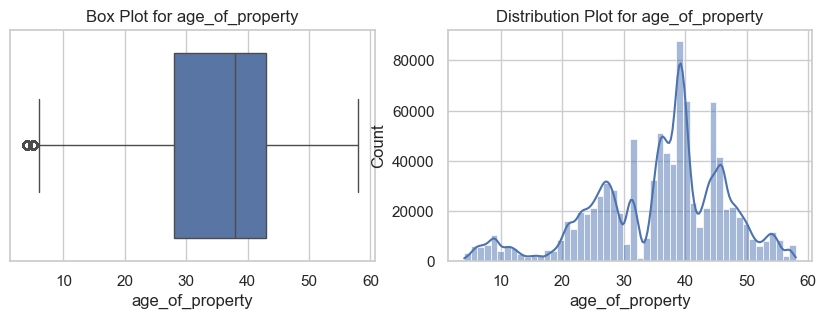

In [55]:
# Visualise these values with plots - box and hist:

def plot(df, column):
    plt.figure(figsize=(16,3))
    plt.subplot(1,3,1)
    sns.boxplot(data=df, x=column)
    plt.title(f'Box Plot for {column}')

    plt.subplot(1,3,2)
    sns.histplot(data=df, x=column, kde=True, bins=50)
    plt.title(f'Distribution Plot for {column}')
    plt.show()

for col in numeric_columns:
    plot(df_s, col)

In [56]:
df_s.describe()

,block,floor_area_sqm,lease_commence_date,resale_price,remaining_lease,Year,Month,sqm_rate,property_holding_age,age_of_property
count,933251.000000,933251.000000,933251.000000,9.332510e+05,933251.000000,933251.000000,933251.000000,933251.000000,933251.000000,933251.000000
mean,348.861471,95.685068,1988.340783,3.227001e+05,79.430667,2006.286355,6.552571,3338.505377,17.945572,35.659217
std,255.116548,25.814477,10.728974,1.722644e+05,10.567985,9.401149,3.402844,1553.496214,10.768320,10.728974
min,1.000000,28.000000,1966.000000,5.000000e+03,41.000000,1990.000000,1.000000,161.290323,0.000000,4.000000
25%,127.000000,73.000000,1981.000000,1.945000e+05,72.000000,1999.000000,4.000000,2295.833333,9.000000,28.000000
50%,302.000000,93.000000,1986.000000,2.990000e+05,81.000000,2005.000000,7.000000,2968.750000,16.000000,38.000000
75%,534.000000,113.000000,1996.000000,4.200000e+05,88.000000,2014.000000,9.000000,4228.260870,25.000000,43.000000
max,999.000000,366.700000,2020.000000,1.588000e+06,97.000000,2024.000000,12.000000,15591.397849,58.000000,58.000000


### Inference: 
From the plots above, we see that floor_area_sqm, resale_price, remaining_lease, sqm_rate and property_holding_age are showing some positive skewness while the other columns are close to symmetrically distributed. Hence, these columns would have to be treated from skewness.

In [57]:
df_s.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,Year,Month,sqm_rate,property_holding_age,age_of_property
0,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,84.0,1990,1,290.322581,13,47
1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,84.0,1990,1,193.548387,13,47
2,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,84.0,1990,1,258.064516,13,47
3,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,84.0,1990,1,193.548387,13,47
4,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,83.0,1990,1,646.575342,14,48


In [58]:
df_s.isnull().sum()

town                    0
flat_type               0
block                   0
street_name             0
storey_range            0
floor_area_sqm          0
flat_model              0
lease_commence_date     0
resale_price            0
remaining_lease         0
Year                    0
Month                   0
sqm_rate                0
property_holding_age    0
age_of_property         0
dtype: int64

### Choosing the transformations:
We will choose the **log transformation** as a way to handle our skewness in data.

In [156]:
df_log = df_s.copy()
df_log.info()

<class 'pandas.core.frame.DataFrame'>
Index: 933251 entries, 0 to 933301
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   town                  933251 non-null  object 
 1   flat_type             933251 non-null  object 
 2   block                 933251 non-null  int64  
 3   street_name           933251 non-null  object 
 4   storey_range          933251 non-null  object 
 5   floor_area_sqm        933251 non-null  float64
 6   flat_model            933251 non-null  object 
 7   lease_commence_date   933251 non-null  int64  
 8   resale_price          933251 non-null  float64
 9   remaining_lease       933251 non-null  float64
 10  Year                  933251 non-null  int32  
 11  Month                 933251 non-null  int32  
 12  sqm_rate              933251 non-null  float64
 13  property_holding_age  933251 non-null  int64  
 14  age_of_property       933251 non-null  int64  
dtypes: fl

In [157]:
df_log.describe()

,block,floor_area_sqm,lease_commence_date,resale_price,remaining_lease,Year,Month,sqm_rate,property_holding_age,age_of_property
count,933251.000000,933251.000000,933251.000000,9.332510e+05,933251.000000,933251.000000,933251.000000,933251.000000,933251.000000,933251.000000
mean,348.861471,95.685068,1988.340783,3.227001e+05,79.430667,2006.286355,6.552571,3338.505377,17.945572,35.659217
std,255.116548,25.814477,10.728974,1.722644e+05,10.567985,9.401149,3.402844,1553.496214,10.768320,10.728974
min,1.000000,28.000000,1966.000000,5.000000e+03,41.000000,1990.000000,1.000000,161.290323,0.000000,4.000000
25%,127.000000,73.000000,1981.000000,1.945000e+05,72.000000,1999.000000,4.000000,2295.833333,9.000000,28.000000
50%,302.000000,93.000000,1986.000000,2.990000e+05,81.000000,2005.000000,7.000000,2968.750000,16.000000,38.000000
75%,534.000000,113.000000,1996.000000,4.200000e+05,88.000000,2014.000000,9.000000,4228.260870,25.000000,43.000000
max,999.000000,366.700000,2020.000000,1.588000e+06,97.000000,2024.000000,12.000000,15591.397849,58.000000,58.000000


In [158]:
skewed_cols = ['floor_area_sqm', 'resale_price', 'remaining_lease', 'sqm_rate']
for col in skewed_cols:
    print(col)
    print(skew(df_log[col]))

floor_area_sqm
0.3668224932849848
resale_price
0.9561178423312855
remaining_lease
-0.6460161882267788
sqm_rate
1.0890133099777124


In [159]:
# using log for skew transformation:
df_log['sqm_rate_log'] = np.log(df_log['sqm_rate'])
df_log['floor_area_sqm_log'] = np.log(df_log['floor_area_sqm'])
df_log['remaining_lease_log']= np.log(df_log['remaining_lease'])
df_log['resale_price_log'] = np.log(df_log['resale_price'])

In [160]:
cols_old = ['sqm_rate','floor_area_sqm','remaining_lease','resale_price']
cols_new = ['sqm_rate_log','floor_area_sqm_log','remaining_lease_log','resale_price_log']

for col in cols_old:
    print(col)
    print("Old skew:\n", skew(df_log[col]))

for col in cols_new:
    print(col)
    print("New skew:\n",skew(df_log[col]))

sqm_rate
Old skew:
 1.0890133099777124
floor_area_sqm
Old skew:
 0.3668224932849848
remaining_lease
Old skew:
 -0.6460161882267788
resale_price
Old skew:
 0.9561178423312855
sqm_rate_log
New skew:
 -0.8023734103552941
floor_area_sqm_log
New skew:
 -0.23470322524196618
remaining_lease_log
New skew:
 -0.9685794662011696
resale_price_log
New skew:
 -0.9166987423605574


In [161]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
Index: 933251 entries, 0 to 933301
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   town                  933251 non-null  object 
 1   flat_type             933251 non-null  object 
 2   block                 933251 non-null  int64  
 3   street_name           933251 non-null  object 
 4   storey_range          933251 non-null  object 
 5   floor_area_sqm        933251 non-null  float64
 6   flat_model            933251 non-null  object 
 7   lease_commence_date   933251 non-null  int64  
 8   resale_price          933251 non-null  float64
 9   remaining_lease       933251 non-null  float64
 10  Year                  933251 non-null  int32  
 11  Month                 933251 non-null  int32  
 12  sqm_rate              933251 non-null  float64
 13  property_holding_age  933251 non-null  int64  
 14  age_of_property       933251 non-null  int64  
 15  sqm_r

### Outliers treatment:

In [162]:
# Outliers handle with IQR and cliping method 

def outlier(df, column):
    # IQR = Q3 - Q1
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    upper_threshold = df[column].quantile(0.75) + (1.5*iqr)
    lower_threshold = df[column].quantile(0.25) - (1.5*iqr)
    df[column] = df[column].clip(lower_threshold, upper_threshold)

# Using the function created to handle outliers in our dataset:
outlier(df_log, 'floor_area_sqm_log')
outlier(df_log,'sqm_rate_log')
outlier(df_log,'remaining_lease_log')
outlier(df_log,'resale_price_log')

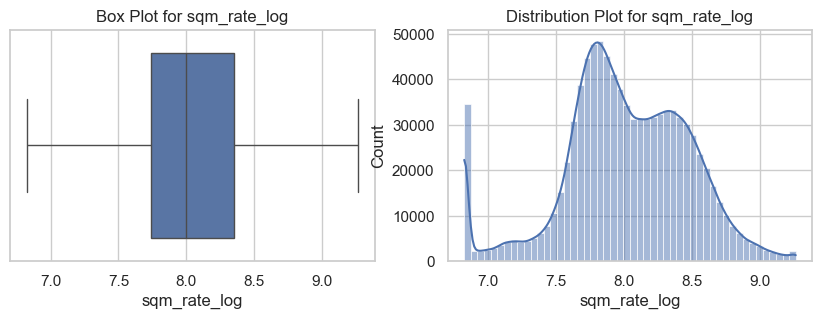

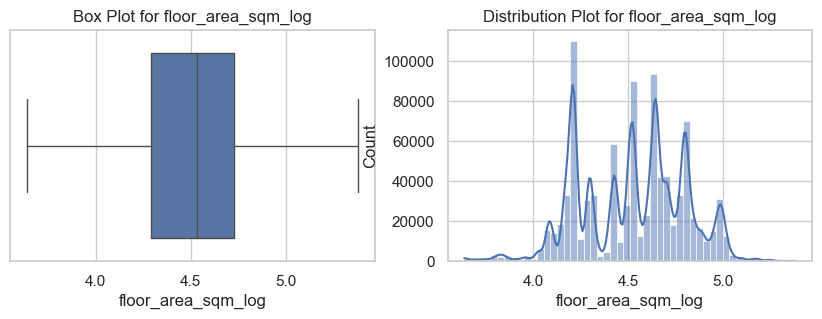

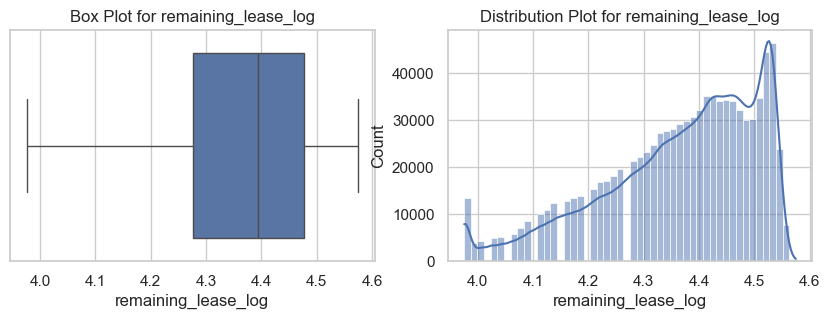

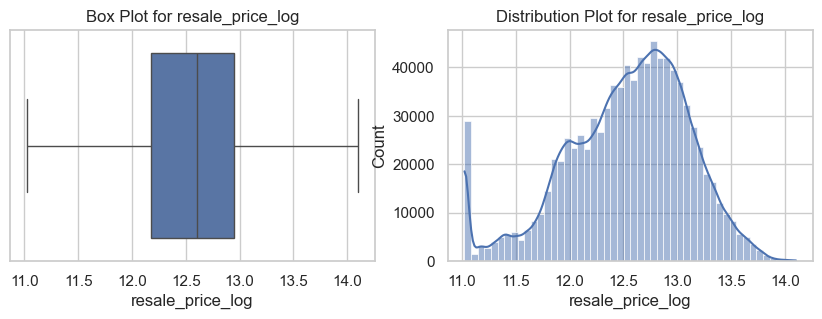

In [163]:
# Visualise these values with plots - box and hist:

def plot(df, column):
    plt.figure(figsize=(16,3))
    plt.subplot(1,3,1)
    sns.boxplot(data=df, x=column)
    plt.title(f'Box Plot for {column}')

    plt.subplot(1,3,2)
    sns.histplot(data=df, x=column, kde=True, bins=50)
    plt.title(f'Distribution Plot for {column}')
    plt.show()

for col in cols_new:
    plot(df_log, col)

## Feature Engineering
Here, we are going to do a few things that facilitate modelling:

* *Correlation* - We will drop highly related fields which makes our modelling robust.
* *Encoding* - By this way, we can make use of categorical values for our modelling.

### Correlation - with heatmap

In [164]:
df_cor = df_log.copy(True)

In [165]:
df_cor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 933251 entries, 0 to 933301
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   town                  933251 non-null  object 
 1   flat_type             933251 non-null  object 
 2   block                 933251 non-null  int64  
 3   street_name           933251 non-null  object 
 4   storey_range          933251 non-null  object 
 5   floor_area_sqm        933251 non-null  float64
 6   flat_model            933251 non-null  object 
 7   lease_commence_date   933251 non-null  int64  
 8   resale_price          933251 non-null  float64
 9   remaining_lease       933251 non-null  float64
 10  Year                  933251 non-null  int32  
 11  Month                 933251 non-null  int32  
 12  sqm_rate              933251 non-null  float64
 13  property_holding_age  933251 non-null  int64  
 14  age_of_property       933251 non-null  int64  
 15  sqm_r

In [166]:
# removing those columns with skewness:
df_cor.drop(columns=['sqm_rate','remaining_lease','floor_area_sqm','resale_price'], inplace=True)

<Axes: >

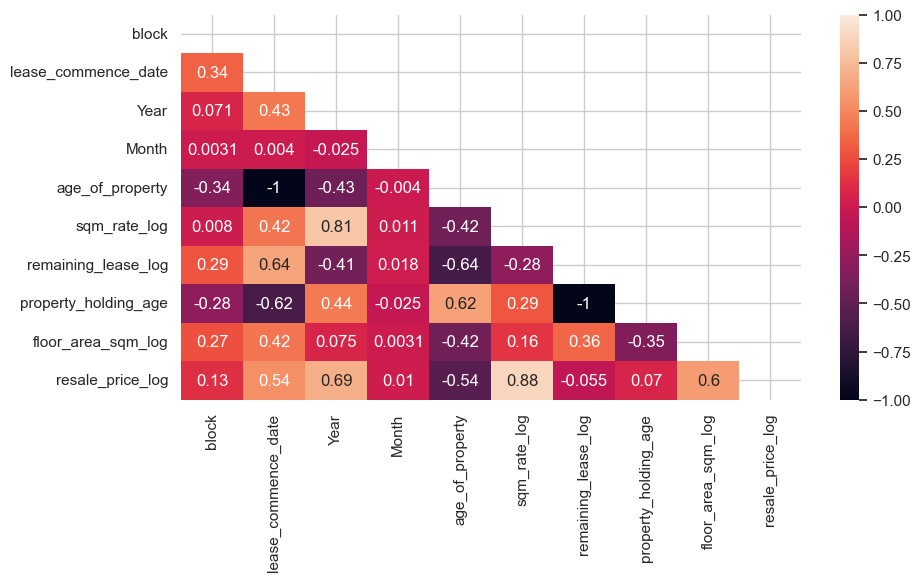

In [168]:
corr = df_cor[['block', 'lease_commence_date', 'Year', 'Month', 'age_of_property','sqm_rate_log','remaining_lease_log','property_holding_age','floor_area_sqm_log','resale_price_log']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True, mask=mask, vmin=-1, vmax=1)

### Statistical Inference and correction:

* Remaining lease variable seems to be highly correlated to two other independent variables. 
* Property_holding_age has a correlation with 3 other independent variables.
* Both age of property and lease commence date are fully correlated.

### Encoding categorical fields:
We have a few categorical fields that needs to be encoded

In [169]:
df0 = df_cor.copy(True)
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 933251 entries, 0 to 933301
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   town                  933251 non-null  object 
 1   flat_type             933251 non-null  object 
 2   block                 933251 non-null  int64  
 3   street_name           933251 non-null  object 
 4   storey_range          933251 non-null  object 
 5   flat_model            933251 non-null  object 
 6   lease_commence_date   933251 non-null  int64  
 7   Year                  933251 non-null  int32  
 8   Month                 933251 non-null  int32  
 9   property_holding_age  933251 non-null  int64  
 10  age_of_property       933251 non-null  int64  
 11  sqm_rate_log          933251 non-null  float64
 12  floor_area_sqm_log    933251 non-null  float64
 13  remaining_lease_log   933251 non-null  float64
 14  resale_price_log      933251 non-null  float64
dtypes: fl

In [170]:
def encoder(df,columns):
    le=LabelEncoder()
    df[columns]=le.fit_transform(df[columns])
    unique_labels = le.classes_
    encoded_values = le.transform(unique_labels)

    for i,j in zip(unique_labels,encoded_values):
        print(i,':',j)

#### Encoding the categorical variables with the encoder function:

In [171]:
encoder(df0,'town')

ANG MO KIO : 0
BEDOK : 1
BISHAN : 2
BUKIT BATOK : 3
BUKIT MERAH : 4
BUKIT PANJANG : 5
BUKIT TIMAH : 6
CENTRAL AREA : 7
CHOA CHU KANG : 8
CLEMENTI : 9
GEYLANG : 10
HOUGANG : 11
JURONG EAST : 12
JURONG WEST : 13
KALLANG/WHAMPOA : 14
LIM CHU KANG : 15
MARINE PARADE : 16
PASIR RIS : 17
PUNGGOL : 18
QUEENSTOWN : 19
SEMBAWANG : 20
SENGKANG : 21
SERANGOON : 22
TAMPINES : 23
TOA PAYOH : 24
WOODLANDS : 25
YISHUN : 26


In [172]:
encoder(df0,'flat_type')

1 ROOM : 0
2 ROOM : 1
3 ROOM : 2
4 ROOM : 3
5 ROOM : 4
EXECUTIVE : 5
MULTI GENERATION : 6


In [173]:
encoder(df0, 'flat_model')

2-ROOM : 0
3GEN : 1
ADJOINED FLAT : 2
APARTMENT : 3
DBSS : 4
IMPROVED : 5
IMPROVED-MAISONETTE : 6
MAISONETTE : 7
MODEL A : 8
MODEL A-MAISONETTE : 9
MODEL A2 : 10
MULTI GENERATION : 11
NEW GENERATION : 12
PREMIUM APARTMENT : 13
PREMIUM APARTMENT LOFT : 14
PREMIUM MAISONETTE : 15
SIMPLIFIED : 16
STANDARD : 17
TERRACE : 18
TYPE S1 : 19
TYPE S2 : 20


In [174]:
encoder(df0,'storey_range')

01 TO 03 : 0
01 TO 05 : 1
04 TO 06 : 2
06 TO 10 : 3
07 TO 09 : 4
10 TO 12 : 5
11 TO 15 : 6
13 TO 15 : 7
16 TO 18 : 8
16 TO 20 : 9
19 TO 21 : 10
21 TO 25 : 11
22 TO 24 : 12
25 TO 27 : 13
26 TO 30 : 14
28 TO 30 : 15
31 TO 33 : 16
31 TO 35 : 17
34 TO 36 : 18
36 TO 40 : 19
37 TO 39 : 20
40 TO 42 : 21
43 TO 45 : 22
46 TO 48 : 23
49 TO 51 : 24


In [175]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 933251 entries, 0 to 933301
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   town                  933251 non-null  int32  
 1   flat_type             933251 non-null  int32  
 2   block                 933251 non-null  int64  
 3   street_name           933251 non-null  object 
 4   storey_range          933251 non-null  int32  
 5   flat_model            933251 non-null  int32  
 6   lease_commence_date   933251 non-null  int64  
 7   Year                  933251 non-null  int32  
 8   Month                 933251 non-null  int32  
 9   property_holding_age  933251 non-null  int64  
 10  age_of_property       933251 non-null  int64  
 11  sqm_rate_log          933251 non-null  float64
 12  floor_area_sqm_log    933251 non-null  float64
 13  remaining_lease_log   933251 non-null  float64
 14  resale_price_log      933251 non-null  float64
dtypes: fl

In [176]:
df0.drop(columns = 'street_name', inplace = True)

## Data Modelling:
* Data split - train_test_split
* Prediction algorithms to use - Linear regression, Random Forest Regressor, Desicion Tree regressor, Extra Trees Regressor

In [177]:
df = df0.copy(True)

In [179]:
# Data spliting:

X = df.drop(['resale_price_log'],axis=1)
y = df['resale_price_log']

X.shape, y.shape

((933251, 13), (933251,))

In [180]:
# split the data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

### Models of choice for regression to predict resale_price:
We will be using 4 regression models here: *Linear Regression, Random Forest Regressor, Extra Trees Regressor, Decision Tree Regressor*. 

In [181]:
# Create an instance of each regression model
lin_model = LinearRegression()
rand_model = RandomForestRegressor()
dt_model = DecisionTreeRegressor()
et_model = ExtraTreesRegressor()

In [182]:
# 1. Linear Regression:
lin_model.fit(X_train, y_train)
lin_preds = lin_model.predict(X_test) # make predictions
# Evaluate the model performance:
lin_mse = mean_squared_error(y_test, lin_preds)
lin_mae = mean_absolute_error(y_test, lin_preds)
lin_r2 = r2_score(y_test, lin_preds)

In [184]:
# 2. Random forest regressor:
rand_model.fit(X_train, y_train)
rand_preds = rand_model.predict(X_test) # make predictions
# Evaluate the model performance:
rand_mse = mean_squared_error(y_test, rand_preds)
rand_mae = mean_absolute_error(y_test, rand_preds)
rand_r2 = r2_score(y_test, rand_preds)

In [183]:
# 3. Decision Tree Regressor:
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_preds)
dt_mae = mean_absolute_error(y_test, dt_preds)
dt_r2 = r2_score(y_test, dt_preds)

In [185]:
# 4. Extra Trees Regressor:
et_model.fit(X_train, y_train)
et_preds = et_model.predict(X_test)
et_mse = mean_squared_error(y_test, et_preds)
et_mae = mean_absolute_error(y_test, et_preds)
et_r2 = r2_score(y_test, et_preds)

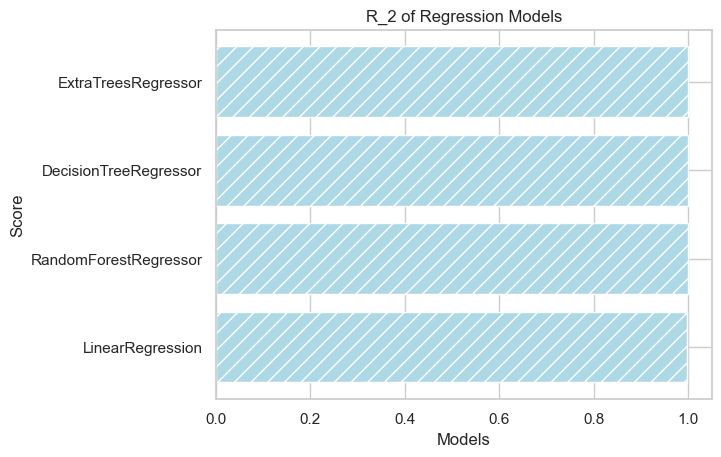

FINDING BEST FIT MODEL FOR EVALUATION BASED ON R_2 SCORE

LinearRegression 0.9972461937081865
RandomForestRegressor 0.9997303966745144
DecisionTreeRegressor 0.9994962533103665
ExtraTreesRegressor 0.9996915849893341

Best Model: RandomForestRegressor contain Maximum R2_Score: 0.9997303966745144 


In [186]:
# Finding the best model based on the R2 score:

models = ['LinearRegression', 'RandomForestRegressor', 'DecisionTreeRegressor','ExtraTreesRegressor']
score = [lin_r2, rand_r2, dt_r2, et_r2]

plt.barh(models, score, color='lightblue',hatch='//')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('R_2 of Regression Models')
plt.show()

print("FINDING BEST FIT MODEL FOR EVALUATION BASED ON R_2 SCORE\n")
max_score = max(score)  # Initialize max_score with the maximum value in the score list
max_model = ""

for model, score_value in zip(models, score):
    print(model, score_value)
    if score_value == max_score:
        max_model = model

print(f"\nBest Model: {max_model} contain Maximum R2_Score: {max_score} ")

In [187]:
lin_rmse = np.sqrt(mean_squared_error(y_test, lin_preds))
rand_rmse = np.sqrt(mean_squared_error(y_test, rand_preds))
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_preds))
et_rmse = np.sqrt(mean_squared_error(y_test, et_preds))

In [188]:
# print the scores:
print("MAE scores: ", lin_mae, rand_mae, dt_mae, et_mae )
print("RMSE scores: ", lin_rmse, rand_rmse, dt_rmse, et_rmse)
print("R2 scores: ", lin_r2, rand_r2, dt_r2, et_r2)

MAE scores:  0.007882680949449643 0.0010481050422716234 0.0013590032327068778 0.0011747625413438152
RMSE scores:  0.03037076180107496 0.00950280054882553 0.012989579560320088 0.010163814854307597
R2 scores:  0.9972461937081865 0.9997303966745144 0.9994962533103665 0.9996915849893341


### Inference from models:
From all the models, it seems that Random Forest is the highest performer considering the R2 scores, followed very very closely by extra trees and decision tree regressor.

* Linear regression shows a significantly lower r2 score, hence we are not considering it.
* Decision tree regressor may be overfitting
* Random forest regressor (topping the score) generally gives a good balance between performance and robustness of model.
* Extra trees regressor is a good alternative to random forest if it is too slow.

In [189]:
# model naming:
ran_model = rand_model.fit(X_train, y_train)

sqm_rate_log            0.798606
floor_area_sqm_log      0.190601
flat_type               0.010470
block                   0.000080
town                    0.000047
Month                   0.000041
flat_model              0.000028
storey_range            0.000028
lease_commence_date     0.000024
age_of_property         0.000021
remaining_lease_log     0.000020
Year                    0.000019
property_holding_age    0.000016
dtype: float64


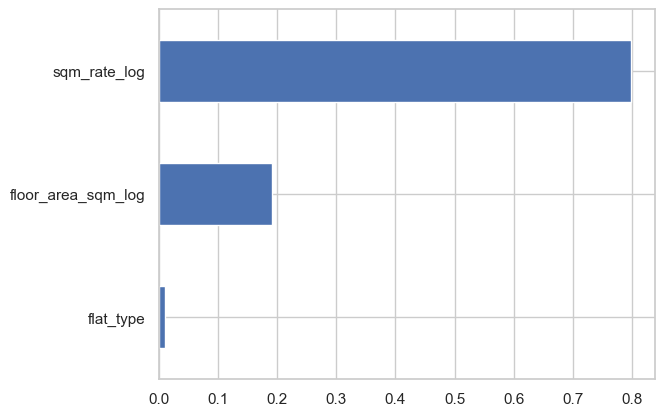

In [190]:
#checking the features scores and importants
feature_scores = pd.Series(ran_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_scores)

# visualising the important features:
feature_scores.nlargest(3).plot(kind='barh').invert_yaxis()

In [191]:
# tuning the decision tree model:
model_dt = DecisionTreeRegressor(max_depth=20,min_samples_leaf=2,min_samples_split=2,random_state=5)
model_dt.fit(X_train, y_train)

y_pred = model_dt.predict(X_test)

# evaluation metrics 
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = metrics.r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {MAE}")
print(f"Mean Squared Error: {MSE}")
print(f"Root Mean Squared Error: {RMSE}")
print(f"R-squared: {r2}")

Mean Absolute Error: 0.001312710384367364
Mean Squared Error: 0.0001314358942423856
Root Mean Squared Error: 0.011464549456580734
R-squared: 0.9996075936732434


### Model inference:
We see that all of our models have performed well, however, the best model to select would be either the Random forest or the Extra trees model. We will go with our scores of *MSE and RMSE* which are essential for a regression model. Through comparison, we can see that the **Random Forest Regressor** model has the best result in terms of all the individual and overall r2 scores.

In [206]:
# pickling the model:
# creating a pickle file of that:
file_path='RandomForestRegressor.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(ran_model, file)
print(f'Pickle file created: {file_path}')

Pickle file created: RandomForestRegressor.pkl


In [207]:
model_et = et_model.fit(X_train, y_train)
model_dt = model_dt.fit(X_train, y_train)

# pickling all the models:
file_path1='ExtraTreesRegressor.pkl'
with open(file_path1, 'wb') as file:
    pickle.dump(model_et, file)
print(f'Pickle file created: {file_path1}')

file_path2='DecisionTreeRegressor.pkl'
with open(file_path2, 'wb') as file:
    pickle.dump(model_dt, file)
print(f'Pickle file created: {file_path2}')

Pickle file created: ExtraTreesRegressor.pkl
Pickle file created: DecisionTreeRegressor.pkl


In [144]:
df.head(2)

,town,flat_type,block,storey_range,flat_model,lease_commence_date,Year,Month,property_holding_age,age_of_property,sqm_rate_sqrt,floor_area_sqm_sqrt,remaining_lease_sqrt,resale_price_sqrt
0,0,0,309,5,5,1977,1990,1,13,47,22.249519,5.567764,9.165151,130.442749
1,0,0,309,2,5,1977,1990,1,13,47,22.249519,5.567764,9.165151,130.442749


In [205]:
predict = ran_model.predict(np.array([[0,1,200,5,5,1977,1997,1,27,47,30.2495,8.9865,8.1651]]))
print(np.exp(predict[0]))

1131620.8261311816
